In [1]:
import numpy as np                # library for mathematical operations with arrays
import pandas as pd               # library for data frames; includes useful functions for date arithmetic
import xarray as xr               # library for arrays, especially tailored to weather data
import matplotlib.pyplot as plt   # library for basic plotting

from os import path                                         # library for operating system commands related to file paths
from matplotlib.colors import ListedColormap                # function for creating custom colormap
from scipy.ndimage import median_filter                     # function for smoothing images
from confer_wp3.onset import calculate_onset_hist           # function to calculate historical rainy season onset dates
from confer_wp3.onset import calculate_adjusted_thresholds  # function to calculate the bias-corrected threshold values
from confer_wp3.onset import calculate_onset_fcst           # function to calculate rainy season onset forecasts
from confer_wp3.plotting import plot_fields                 # function for visualizing spatial data in a map
from scipy.stats import spearmanr                           # Spearman correlation (for forecast verification)

from confer_wp3.glp import domain_boundaries, global_parameters  # global parameters
from confer_wp3.utils import month_init_dict                     # translates from 3-character string to integer
from confer_wp3.utils import load_onset_parameter                # loads pre-defined parameters for onset definition from file

In [2]:
fcst_dir = '/home/confer/michael/Data/Forecasts_daily_nc/'
chirps_dir = '/home/confer/michael/Data/CHIRPS_daily/'
output_dir = '/home/confer/michael/Data/Forecasts_onset/'
mask_dir = '/home/confer/michael/Data//Mask/'
colors_dir = '/home/confer/michael/CONFER-WP3/data/'

#fcst_dir = '/home/michael/nr/samba/PostClimDataNoBackup/CONFER/Data/Forecasts_daily_nc/'
#chirps_dir = '/home/michael/nr/samba/PostClimDataNoBackup/CONFER/Data/CHIRPS_daily/'
#output_dir = '/home/michael/nr/samba/PostClimDataNoBackup/CONFER/Data/Output/'
#mask_dir = '/home/michael/nr/samba/PostClimDataNoBackup/CONFER/Data/Mask/'
#colors_dir = '/home/michael/Projects/CONFER/CONFER-WP3/data/'

Set the variables that define the season and region in which we search for rainy season onset, and four parameters that determine how the rainy season onset date is defined.

The default values used by ICPAC are thr_dry_day = 1, thr_wet_spell = 20, wnd_dry_spell = 21, and len_dry_spell = 7. However, for drier regions within GHA, these values can lead to a large number of years with a 'failed onset' because the onset criterion is not met. We therefore ask users to provide two values for each parameter. The first value will be used for the driest 33% grid points within GHA for the selected season, the second value will be used for the remaining grid points.

In [3]:
region = 'GHA'         # Either 'GHA' for the entire domain or any country name within the GHA region

year_clm_start = 1991  # first year of the climatological reference period
year_clm_end = 2023    # last year fof the climatological reference period

month_start = 'may'    # month in which we start the onset date search (specifically: the 15th of this month)
system = 'wrf_d01'     # forecast system on which the rainy season onset forecasts will be based

thr_dry_day = [0.5,1.0]    # the daily rainfall amount below which the day will be considered a 'dry day'
thr_wet_spell = [10.,20.]  # the rainfall amount within 3 days required to consider these days a 'wet spell'
wnd_dry_spell = [10,21]    # time window after the 3-day wet spell within which to check for dry spells
len_dry_spell = [5,7]      # number of consecutive dry days within this time window that will invalidate an onset

season = 'JJAS'         # 'MAM', 'JJAS', or 'OND'

Load some global parameters and construct the masks with the regionalized parameters for the rainy season onset criterion:

In [4]:
lon_bounds, lat_bounds = domain_boundaries(region)
day_start, nwks, ndts, ntwd = global_parameters()

date_start = f'{year_clm_start}-{month_init_dict[month_start]}-{day_start}'

f1 = np.load(colors_dir+'onset_colors.npz')
onsetcol = f1['onsetcol']
f1.close()
newcmp_onset = ListedColormap(onsetcol)

f2 = np.load(colors_dir+'tercile_colors.npz')
tercilecol = f2['tercilecol']
f2.close()
newcmp_tercile = ListedColormap(tercilecol)

if isinstance(thr_dry_day, list):
    thr_dry_day = load_onset_parameter('thr_dry_day', thr_dry_day, season, lon_bounds, lat_bounds, mask_dir)

if isinstance(thr_wet_spell, list):
    thr_wet_spell = load_onset_parameter('thr_wet_spell', thr_wet_spell, season, lon_bounds, lat_bounds, mask_dir)

if isinstance(wnd_dry_spell, list):
    wnd_dry_spell = load_onset_parameter('wnd_dry_spell', wnd_dry_spell, season, lon_bounds, lat_bounds, mask_dir)

if isinstance(len_dry_spell, list):
    len_dry_spell = load_onset_parameter('len_dry_spell', len_dry_spell, season, lon_bounds, lat_bounds, mask_dir)

Load longitude and latitude coordinates of the target grid:

In [5]:
filename_chirps = f'{chirps_dir}/chirps-v2.0.{year_clm_start}.days_p25.nc'
data_load = xr.open_dataset(filename_chirps, engine='netcdf4')
data_subset = data_load.sel(latitude=slice(lat_bounds[0],lat_bounds[1]), longitude=slice(lon_bounds[0],lon_bounds[1]))
lon_chirps = data_subset.longitude.values
lat_chirps = data_subset.latitude.values
data_load.close()

nlat = len(lat_chirps)
nlon = len(lon_chirps)

Visualize the regionalized parameters for the rainy season onset criterion:

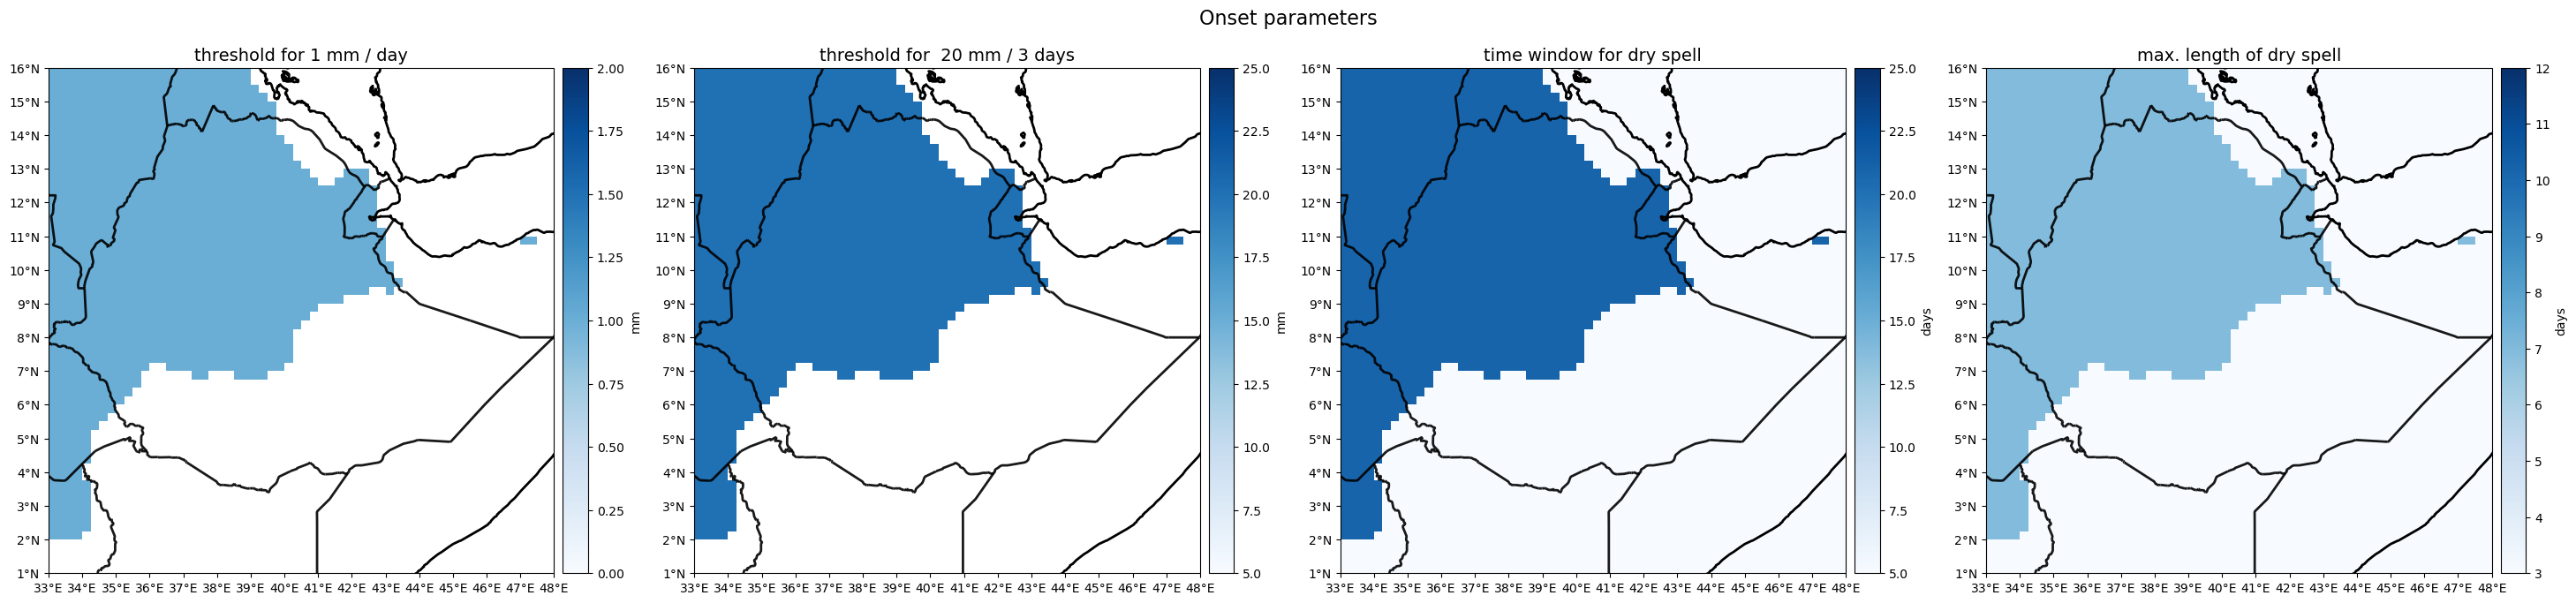

In [6]:
plot_fields (fields_list = [thr_dry_day, thr_wet_spell, wnd_dry_spell, len_dry_spell],
          lon = lon_chirps,
          lat = lat_chirps,
          lon_bounds = lon_bounds,
          lat_bounds = lat_bounds,
          main_title = 'Onset parameters',
          subtitle_list = ['threshold for 1 mm / day','threshold for  20 mm / 3 days', 'time window for dry spell', 'max. length of dry spell'],
          vmin = [0,5,5,3],
          vmax = [2,25,25,12],
          cmap = 'Blues',
          unit = ['mm','mm','days','days'])

Calculate historical rainy season onset dates based on CHIRPSv2 data with the onset definition parameters specified above:

In [7]:
filename_onset_hist = f'{output_dir}onset_historical_{season}_{year_clm_start}_{year_clm_end}.nc'

if path.exists(filename_onset_hist):
    data_load = xr.open_dataset(filename_onset_hist, engine='netcdf4')
    onset_day_hist = data_load.onset_day.values
    data_load.close()
else:
    onset_day_hist = calculate_onset_hist(region, month_init_dict[month_start], year_clm_start, year_clm_end, thr_dry_day, thr_wet_spell, wnd_dry_spell, len_dry_spell, chirps_dir)
    da_onset_hist = xr.DataArray(
        data= onset_day_hist,
        dims=['year','lat','lon'],
        coords={'year': [*range(year_clm_start, year_clm_end+1)], 'lat': lat_chirps, 'lon': lon_chirps,},
        name='onset_day',
        attrs=dict(
            description=f'Start date of the rainy season based on CHIRPSv2 precipitation data',
            units=f"-1: 'failed onset', 1: 15.{month_start.capitalize()}, 2: 16.{month_start.capitalize()}, ...",),
        )
    da_onset_hist.to_netcdf(filename_onset_hist)

onset_week_hist = 1 + (onset_day_hist-1)//7

Loading data ...
Calculating rainy season onset dates for 1991 ...
Calculating rainy season onset dates for 1992 ...
Calculating rainy season onset dates for 1993 ...
Calculating rainy season onset dates for 1994 ...
Calculating rainy season onset dates for 1995 ...
Calculating rainy season onset dates for 1996 ...
Calculating rainy season onset dates for 1997 ...
Calculating rainy season onset dates for 1998 ...
Calculating rainy season onset dates for 1999 ...
Calculating rainy season onset dates for 2000 ...
Calculating rainy season onset dates for 2001 ...
Calculating rainy season onset dates for 2002 ...
Calculating rainy season onset dates for 2003 ...
Calculating rainy season onset dates for 2004 ...
Calculating rainy season onset dates for 2005 ...
Calculating rainy season onset dates for 2006 ...
Calculating rainy season onset dates for 2007 ...
Calculating rainy season onset dates for 2008 ...
Calculating rainy season onset dates for 2009 ...
Calculating rainy season onset da

We check whether over the specified region and with the selected start month and onset definition parameters the historical outcome is mostly (except for 5 years or less) a failed onset; in that case, the respective grid points are masked. We also checl for an immediate (within 5 days of the start of the search period) onset, but we still continue processing grid points for which the rainy season has typically already started at the beginning of the search period:

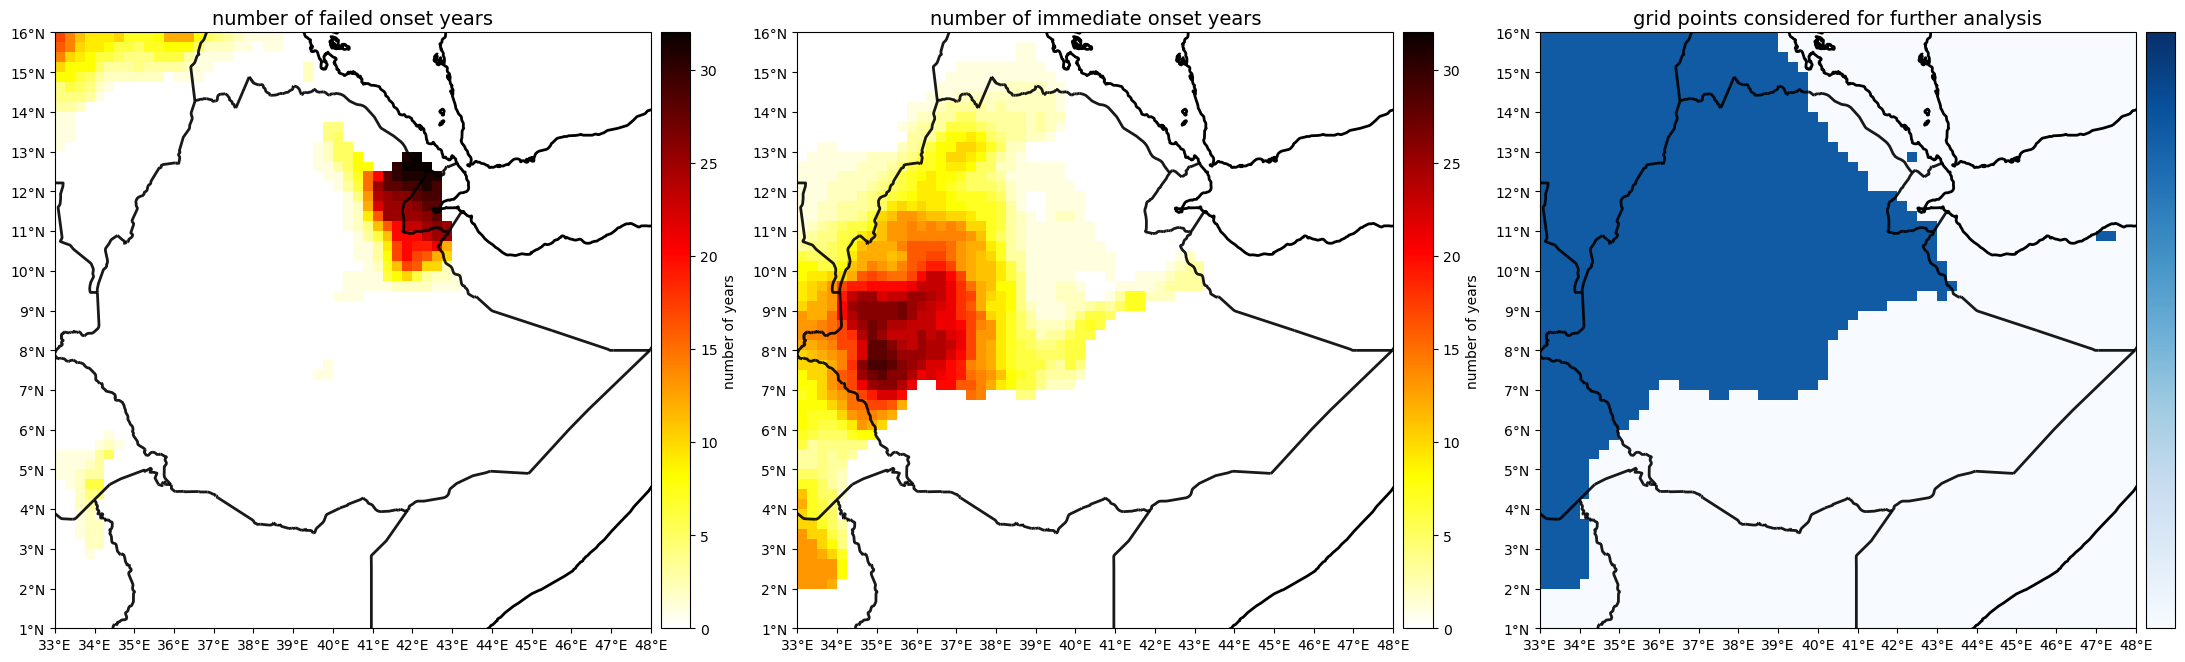

In [8]:
nyrs = onset_day_hist.shape[0]
missing_data_ind = np.all(np.isnan(onset_day_hist), axis=0)
nyrs_failed_onset = np.where(missing_data_ind, np.nan, median_filter(np.sum(onset_day_hist<0, axis=0), size=3))
nyrs_immediate_onset = np.where(missing_data_ind, np.nan, median_filter(np.sum(np.logical_and(onset_day_hist>0, onset_day_hist<6), axis=0), size=3))
#mask = np.logical_or(missing_data_ind, np.logical_or(nyrs_failed_onset>=nyrs-10, nyrs_immediate_onset>=nyrs-10))
mask = np.logical_or(missing_data_ind, nyrs_failed_onset>=nyrs-5)

plot_fields (fields_list = [nyrs_failed_onset, nyrs_immediate_onset, 1*(~mask)],
          lon = lon_chirps,
          lat = lat_chirps,
          lon_bounds = lon_bounds,
          lat_bounds = lat_bounds,
          main_title = '',
          subtitle_list = ['number of failed onset years', 'number of immediate onset years', 'grid points considered for further analysis'],
          cmap = ['hot_r','hot_r','Blues'],
          vmin = 0,
          vmax = [nyrs,nyrs,1.2],
          ticks = [True, True, []],
          tick_labels = [True, True, []],
          unit = ['number of years', 'number of years',''])

if np.mean(~mask) < 0.1:
    print('\nWarning! Less than 10% of the grid points in the selected region is considered for further analysis! \n\nPlease check if the selected start month and parameters defining onset are suitable for this region.\n')

thr_wet_spell[mask] = np.nan
thr_dry_day[mask] = np.nan

Let's calculate and depict the median and lower/upper onset date tercile in a map, using the mask defined above:

/tmp/ipykernel_5594/2776029895.py:1: RuntimeWarning: All-NaN slice encountered
  onset_day_median = np.nanmedian(np.where(onset_day_hist==-1, np.nan, onset_day_hist), axis=0)
/home/confer/mambaforge/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


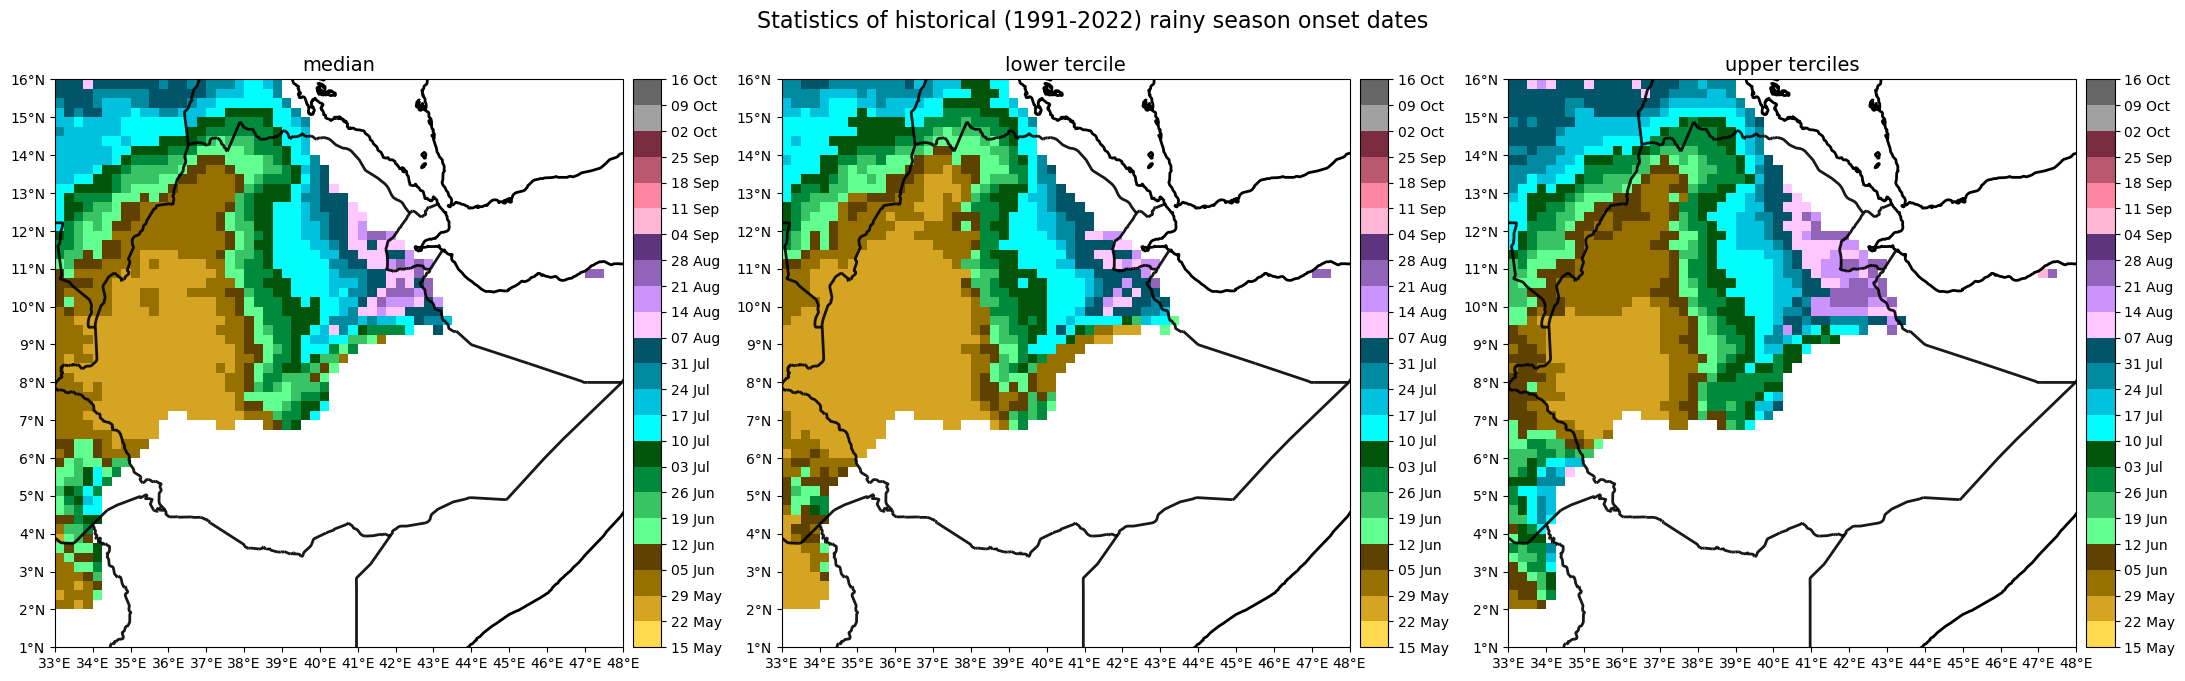

In [9]:
onset_day_median = np.nanmedian(np.where(onset_day_hist==-1, np.nan, onset_day_hist), axis=0)
onset_week_median = np.where(mask, np.nan, 1 + (onset_day_median-1)//7)
onset_day_lower_tercile = np.nanquantile(np.where(onset_day_hist==-1, np.nan, onset_day_hist), q=0.33, axis=0)
onset_week_lower_tercile = np.where(mask, np.nan, 1 + (onset_day_lower_tercile-1)//7)
onset_day_upper_tercile = np.nanquantile(np.where(onset_day_hist==-1, np.nan, onset_day_hist), q=0.67, axis=0)
onset_week_upper_tercile = np.where(mask, np.nan, 1 + (onset_day_upper_tercile-1)//7)

onset_week_labels = [(pd.Timestamp(date_start)+pd.Timedelta(days=7*iwk)).strftime("%d %b") for iwk in range(nwks+1)]

plot_fields (fields_list = [onset_week_lower_tercile, onset_week_median, onset_week_upper_tercile],
          lon = lon_chirps,
          lat = lat_chirps,
          lon_bounds = lon_bounds,
          lat_bounds = lat_bounds,
          main_title = f'Statistics of historical ({year_clm_start}-{year_clm_end}) rainy season onset dates',
          subtitle_list = ['lower tercile', 'median', 'upper terciles'],
          cmap = newcmp_onset,
          vmin = 0,
          vmax = nwks,
          ticks = [*range(nwks+1)],
          tick_labels = onset_week_labels,
          unit = '')

Now we calculate the bias-adjusted threshold parameters for the selected forecast system. For a large region, this can take some time:

In [10]:
filename_thr_adj = f'{output_dir}adjusted_thresholds_{system}_{season}_{year_clm_start}_{year_clm_end}.nc'

if path.exists(filename_thr_adj):
    data_load = xr.open_dataset(filename_thr_adj, engine='netcdf4')
    thr_dry_day_adj = data_load.thr_dry_day_adj.values
    thr_wet_spell_adj = data_load.thr_wet_spell_adj.values
    data_load.close()
else:
    thr_dry_day_adj, thr_wet_spell_adj = calculate_adjusted_thresholds(region, month_start, year_clm_start, year_clm_end, system, thr_dry_day, thr_wet_spell, chirps_dir, fcst_dir, cv=True)
    ds_thr_adj = xr.Dataset(
        {
            'thr_dry_day_adj': (['year','date','lat','lon'], thr_dry_day_adj),
            'thr_wet_spell_adj': (['year','date','lat','lon'], thr_wet_spell_adj),
        },
        coords = {
            'year': [*range(year_clm_start, year_clm_end+1)],
            'date': pd.date_range(date_start, periods=ndts).strftime("%d %b"),
            'lat': lat_chirps,
            'lon': lon_chirps,
        },
    )
    ds_thr_adj.to_netcdf(filename_thr_adj)


Loading CHIRPS data ...
Loading WRF forecast data for 1991 ...
Loading WRF forecast data for 1992 ...
Loading WRF forecast data for 1993 ...
Loading WRF forecast data for 1994 ...
Loading WRF forecast data for 1995 ...
Loading WRF forecast data for 1996 ...


/home/confer/mambaforge/lib/python3.10/site-packages/confer_wp3/onset.py:198: RuntimeWarning: overflow encountered in cast
  prcp_fcst_3d[iyr,:,:,:] = ds.rolling(valid_time=3).sum().precip.values[:,2:,:,:]


Loading WRF forecast data for 1997 ...
Loading WRF forecast data for 1998 ...
Loading WRF forecast data for 1999 ...
Loading WRF forecast data for 2000 ...
Loading WRF forecast data for 2001 ...
Loading WRF forecast data for 2002 ...
Loading WRF forecast data for 2003 ...
Loading WRF forecast data for 2004 ...
Loading WRF forecast data for 2005 ...
Loading WRF forecast data for 2006 ...
Loading WRF forecast data for 2007 ...
Loading WRF forecast data for 2008 ...
Loading WRF forecast data for 2009 ...
Loading WRF forecast data for 2010 ...
Loading WRF forecast data for 2011 ...
Loading WRF forecast data for 2012 ...
Loading WRF forecast data for 2013 ...
Loading WRF forecast data for 2014 ...
Loading WRF forecast data for 2015 ...
Loading WRF forecast data for 2016 ...
Loading WRF forecast data for 2017 ...
Loading WRF forecast data for 2018 ...
Loading WRF forecast data for 2019 ...
Loading WRF forecast data for 2020 ...
Loading WRF forecast data for 2021 ...
Loading WRF forecast data

Now, we are ready to calculate the rainy season onset prediction for the selected year:

In [12]:
filename_onset_fcst = f'{output_dir}onset_forecasts_{system}_{season}_{year_clm_start}_{year_clm_end}.nc'

if path.exists(filename_onset_fcst):
    data_load = xr.open_dataset(filename_onset_fcst, engine='netcdf4')
    onset_day_fcst = data_load.onset_day.values
    data_load.close()
else:
    onset_day_fcst_list = []
    for (iyr, year_fcst) in zip(range(nyrs),[*range(year_clm_start, year_clm_end+1)]):
        onset_day_fcst_list.append(np.expand_dims(calculate_onset_fcst(region, month_start, year_fcst, system, thr_dry_day_adj[iyr,:,:,:], thr_wet_spell_adj[iyr,:,:,:], wnd_dry_spell, len_dry_spell, lat_chirps, lon_chirps, fcst_dir), axis=0))
    
    onset_day_fcst = np.concatenate(onset_day_fcst_list, axis=0)
    da_onset_fcst = xr.DataArray(
        data= onset_day_fcst,
        dims=['year','member','lat','lon'],
        coords={'year': [*range(year_clm_start, year_clm_end+1)], 'member': [*range(1,onset_day_fcst.shape[1]+1)], 'lat': lat_chirps, 'lon': lon_chirps,},
        name='onset_day',
        attrs=dict(
            description=f'Date on which the rainy season is forecast to begin',
            units=f"-1: 'failed onset', 1: 15.{month_start.capitalize()}, 2: 16.{month_start.capitalize()}, ...",),
        )
    da_onset_fcst.to_netcdf(filename_onset_fcst)

Loading and interpolating forecast data ...
Calculating rainy season onset dates ...


# Forecast verification

We now calculate two forecast verification metrics of the rainy season onset date forecasts computed above:
- Spearman rank correlations of ensemble median onset dates with CHIRPS-based onset dates
- Brier skill scores (relative to climatological forecasts) of a multi-category forecast where the first category is 'failed onset' and the other categories correspond to the number of weeks after the start of the search period

The code below also allows one to compose multi-model ensemble forecast, if rainy season onset date forecasts from other systems have previously been computed and are available for use in addition to those computed here. If 'climatology' is added to the list of systems, the ensemble is augmented by the CHIRPS-based rainy season onset dates from the climatological reference period.

In [1]:
systems = ['wrf_d01','wrf_d02','climatology']

Compose a climatological rainy season onset date ensemble via cross-validation of the historical onset dates:

In [ ]:
onset_day_clm = np.full((nyrs,nyrs-1,nlat,nlon), np.nan, dtype=float)
for iyr in range(nyrs):
    onset_day_clm[iyr,:,:,:] = np.delete(onset_day_hist, iyr, axis=0)

Compose the multi-model ensemble of rainy season onset date forecasts and calculate the median forecast and probabilities for the different onset categories:

In [ ]:
onset_day_fcst_list = []

for system in systems:
    if system == 'climatology':
        onset_day_fcst_list.append(onset_day_clm)
    else:
        filename_onset_fcst = f'{output_dir}onset_forecasts_{system}_{season}_{year_clm_start}_{year_clm_end}.nc'
        data_load = xr.open_dataset(filename_onset_fcst, engine='netcdf4')
        onset_day_fcst_list.append(data_load.onset_day.values)
        data_load.close()

onset_day_fcst = np.concatenate(onset_day_fcst_list, axis=1)
onset_day_fcst_median = np.nanmedian(onset_day_fcst, axis=1)
onset_week_fcst = 1 + (onset_day_fcst-1)//7
onset_week_clm = 1 + (onset_day_clm-1)//7

Calculate verification metrics for the multi-model ensemble and the climatological reference, and depict resulting skill scores in a map:

In [ ]:
ncat = 1 + nwks
onset_cat_hist = np.where(mask[None,:,:,None], np.nan, 1.*np.equal.outer(onset_week_hist,np.arange(ncat)))
onset_prob_fcst = np.where(mask[None,:,:,None], np.nan, np.mean(np.equal.outer(onset_week_fcst,np.arange(ncat)), axis=1))
onset_prob_clm = np.where(mask[None,:,:,None], np.nan, np.mean(np.equal.outer(onset_week_clm,np.arange(ncat)), axis=1))

bs_fcst = np.where(mask, np.nan, np.mean(np.sum((onset_cat_hist-onset_prob_fcst)**2, axis=3), axis=0))
bs_clm = np.where(mask, np.nan, np.mean(np.sum((onset_cat_hist-onset_prob_clm)**2, axis=3), axis=0))
bss_fcst = 1 - bs_fcst/bs_clm

spearman_correlation = np.full((nlat, nlon), np.nan, dtype=float)
for ilat in range(nlat):
    for ilon in range(nlon):
        if np.all(np.isnan(onset_day_hist[:,ilat,ilon])):
            continue
        use = np.logical_and(~np.isnan(onset_day_hist[:,ilat,ilon]), ~np.isnan(onset_day_fcst_median[:,ilat,ilon]))
        spearman_correlation[ilat,ilon] = spearmanr(onset_day_fcst_median[:,ilat,ilon][use], onset_day_hist[:,ilat,ilon][use])[0]


plot_fields (fields_list = [spearman_correlation, bss_fcst],
          lon = lon_chirps,
          lat = lat_chirps,
          lon_bounds = lon_bounds,
          lat_bounds = lat_bounds,
          main_title = '',
          subtitle_list = [f'Spearman correlation skill of median onset date forecast','Brier skill score of onset category forecast'],
          cmap = ['bwr_r','bwr_r'],
          vmin = [-1,-0.2],
          vmax = [1,0.2],
          unit = '')